In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import choice

In [2]:
sigmoid = lambda y : 1.0 / (1.0 + np.exp(-y))
sigmoid_prime = lambda z : z * (1.0 - z)
tanh = lambda y : np.tanh(y)
tanh_prime = lambda z : 1.0 - np.power(tanh(z), 2)

## A Few Things to Note: ##
* I tried to do batch gradient descent, to try and save on training time due to the efficiency of a vectorized forwardprop with the whole training set because its only len 4
* Either my implementation of backprop with batch gradient descent was very incorrect, or the XOR problem is simply not suited for BGD. I was averaging the error, and the subsequent changes to all the weights by passing in all 4 of my predictions at once, and this understandably didn't converge to RMSE < .01, as the updates were not all in the same directions, so some of the delta_ws would contradict and the model would not be as aggressive with its updates.
* My forward prop still can take in a full M x N array of inputs, and I use that function for RMSE calculation and for Predicting values in the NN boundaries but I've deleted all the code for my failed attempt at BGD
* Via Leo, I know that you've said the first layer of weights should be 3x2, and we should append its output with a bias, but I had significant difficulties making my backprop work for a 3x2 layer design, and as such have left my layers as they were before Leo asked you about that, with a 3x3 and a 3x1, where a bias is added only to the input
* I was having some trouble with some epochs regressing, so my fit function updates the weights to the best performing epoch of the 10 whose RMSE is reported, and the Fit function returns history of RMSE, Epochs, Weights, as arrays.

* I'm slightly confused on the format of this NN, since we are trying to classify an (x,y) as a 1 or a 0, does it not make more sense for us to output a probability vector using a Softmax? The existing NN has nothing restricting the output to the range \[0,1] so some of the predictions are unnecessarily penalized, say if the model predicts -0.3 when it should be 0. Does this make training more difficult?


In [3]:
class NeuralNetwork():
    def __init__(self, layers, activation='sigmoid', learning_rate = 0.2) -> None:
        '''
        layers takes an array of form [number of inputs, number of neurons in first layer, number of neurons in second layer]
        i.e. in the hw prompt's example X is a (2,4) np array so each input element is a pair (2,)
        output should be a vector of the same number of rows (i.e. (1,4) )
        -Leo
        '''
        if len(layers) < 2:
            raise Exception('Layers parameter is invalid (too few layers)')
        layers = np.array(layers)
        layers[:-1] += 1
        self.layers = []
        for i in range(len(layers) - 1):
            self.layers.append(np.random.randn(layers[i], layers[i + 1]))
        
        # define activation function
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_p = sigmoid_prime
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_p = tanh_prime
        else:
            raise Exception('That activation function is not supported')
        self.alpha = learning_rate
        self.loss = np.array([])
    def forwardprop(self, X, batch=False):
        A_hist = []
        if (not batch):
             X = np.append(1, X) # X is a 1 dim array when batch is False, adding bias
        
        else:
            ones = np.atleast_2d(np.ones(X.shape[0])) # X is a m x n array, adding bias requires a different approach
            X = np.concatenate((ones.T, X), axis=1)
        
        for i in range(len(self.layers)):
            A_hist.append(X)
            A = np.dot(X, self.layers[i])
            X = self.activation(A)
        A_hist.append(X)
        return X, A_hist  # A_hist includes input, A_0, A_1, and z

    def Backprop(self, z, y, A_hist):
        
        error = y - z
        self.loss = np.append(self.loss, error)
        deltas = [error * self.activation_p(z)]
        
        for l in range(len(A_hist) - 2, 0, -1): #work backwards to find the delta_ws for each layer 
            deltas.append(deltas[-1].dot(self.layers[l].T)*self.activation_p(A_hist[l])) 
        
        deltas.reverse() #reverse the list so we can update the layers sequentially 
        
        for i in range(len(self.layers)):
            layer = np.atleast_2d(A_hist[i]) #input into the layer that's being updated
            
            delta = np.atleast_2d(deltas[i]) #delta_w
            
            self.layers[i] += self.alpha * layer.T.dot(delta)
            
    def find_RMS_error(self, X, y):
        return np.sqrt(np.power((y-X),2).sum()/len(X))
        
    def fit(self, X, y,learning_rate=1, steps=20000, tol=0.01):
        y = y.reshape(y.shape[0],1) # This exists simply because I had defined my y array 
                                    # differently to how Prof has it defined in the writeup, when I realized everything broke
        self.alpha = learning_rate
        RMSEHistory = []
        EpochHistory = []
        Whist = []
        for i in range(steps+1):
            
            stochastic = choice(range(len(X)))
            z, A_hist = self.forwardprop(X[stochastic])
            self.Backprop(z,y[stochastic], A_hist) # Stochastic Gradient Descent
            
            if (i%(steps/10) == 0):
                z,_ = self.forwardprop(X, batch = True) # get outputs for the entire training set
                RMSE = self.find_RMS_error(z, y) 
                RMSEHistory.append(RMSE)
                EpochHistory.append(i)
                Whist.append(self.layers)
                print(f'step: {i}\nTraining Results(data, prediction, expected)') # live update the training
                for i in range(len(X)):
                    print(f'{X[i]}, {z[i]}, {y[i]}')
                print(f'RMSE: {RMSE}')
                if RMSE < tol:
                    print('NN training succeeded!')
                    break
        self.layers = Whist[np.argmin(RMSEHistory)] # Update the weights in self.layers to the best performing layer
        return RMSEHistory, EpochHistory, Whist
    
    def predict(self, x, threshold = 0.5):
        # returns z array of just True/False according to whatever the threshold was
        z,_= self.forwardprop(x, batch = True)
        return z>threshold
    
    def visual_NN_boundaries(self, Nsampp=2000, threshold = 0.5):
        x = np.random.rand(Nsampp, 2)
        z = self.predict(x, threshold)
        plt.scatter(x[:,0], x[:,1], cmap = 'coolwarm', c=z)
        plt.title('Neural Network boundaries')
        plt.xlabel('X value of input')
        plt.ylabel('Y value of input')
        plt.show()

In [4]:
X = np.array([[0, 0],
[0, 1],
[1, 0],
[1, 1]])
y = np.array([0, 1, 1, 0])

In [5]:
#%%timeit -r 10 -n 10
nn = NeuralNetwork([2,2,1])
RMSE, Epochs, Weights = nn.fit(X,y)

step: 0
Training Results(data, prediction, expected)
[0 0], [0.57776807], [0]
[0 1], [0.48600683], [1]
[1 0], [0.73419771], [1]
[1 1], [0.68283184], [0]
RMSE: 0.5326619718858991
step: 2000
Training Results(data, prediction, expected)
[0 0], [0.06153001], [0]
[0 1], [0.92027331], [1]
[1 0], [0.93176589], [1]
[1 1], [0.5161444], [0]
RMSE: 0.2651429891328607
step: 4000
Training Results(data, prediction, expected)
[0 0], [0.03252862], [0]
[0 1], [0.95123159], [1]
[1 0], [0.95707586], [1]
[1 1], [0.50497097], [0]
RMSE: 0.2550855901636174
step: 6000
Training Results(data, prediction, expected)
[0 0], [0.02327364], [0]
[0 1], [0.96169617], [1]
[1 0], [0.96497771], [1]
[1 1], [0.50174489], [0]
RMSE: 0.25247937628250483
step: 8000
Training Results(data, prediction, expected)
[0 0], [0.01817199], [0]
[0 1], [0.9470058], [1]
[1 0], [0.93788064], [1]
[1 1], [0.47843089], [0]
RMSE: 0.242844362042044
step: 10000
Training Results(data, prediction, expected)
[0 0], [0.04802992], [0]
[0 1], [0.95854691

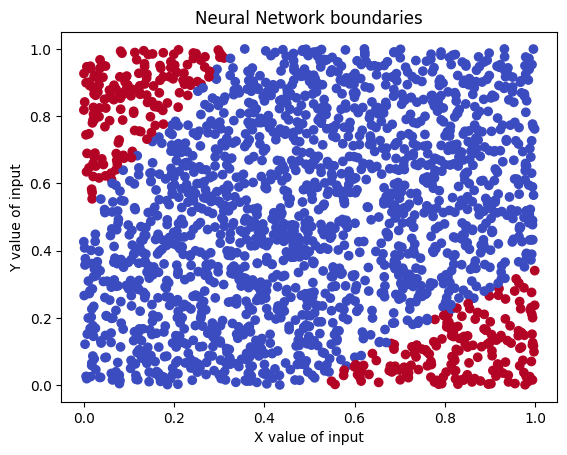

In [6]:
nn.visual_NN_boundaries(threshold = 0.5)

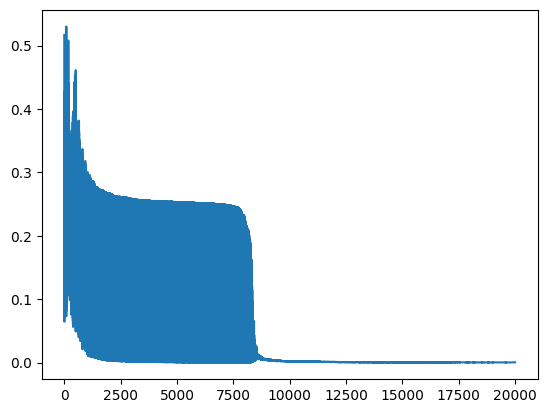

In [7]:
plt.plot(np.power(nn.loss, 2))

In [8]:
X = np.array([[0, 0],
[0, 1],
[0.5, 1],
[0, 0.5],
[1, 0],
[1, 1]])
y = np.array([[0], [0], [0], [1], [1], [1]])

In [10]:
nn = NeuralNetwork([2, 2, 2, 1], activation = 'sigmoid')
RMSE, Epochs, Weights = nn.fit(X,y, steps = 140000)

step: 0
Training Results(data, prediction, expected)
[0. 0.], [0.43124486], [0]
[0. 1.], [0.40912545], [0]
[0.5 1. ], [0.40807339], [0]
[0.  0.5], [0.41792486], [1]
[1. 0.], [0.43072597], [1]
[1. 1.], [0.40770471], [1]
RMSE: 0.5055653195319849
step: 14000
Training Results(data, prediction, expected)
[0. 0.], [0.03562419], [0]
[0. 1.], [0.03541055], [0]
[0.5 1. ], [0.01915545], [0]
[0.  0.5], [0.9544977], [1]
[1. 0.], [0.994238], [1]
[1. 1.], [0.97935934], [1]
RMSE: 0.03005444681567928
step: 28000
Training Results(data, prediction, expected)
[0. 0.], [0.01585585], [0]
[0. 1.], [0.01622108], [0]
[0.5 1. ], [0.00986433], [0]
[0.  0.5], [0.98010302], [1]
[1. 0.], [0.99592176], [1]
[1. 1.], [0.98928942], [1]
RMSE: 0.013778454127563143
step: 42000
Training Results(data, prediction, expected)
[0. 0.], [0.01180373], [0]
[0. 1.], [0.01168097], [0]
[0.5 1. ], [0.00766574], [0]
[0.  0.5], [0.98554193], [1]
[1. 0.], [0.99655952], [1]
[1. 1.], [0.99195826], [1]
RMSE: 0.010165946041336391
step: 5600

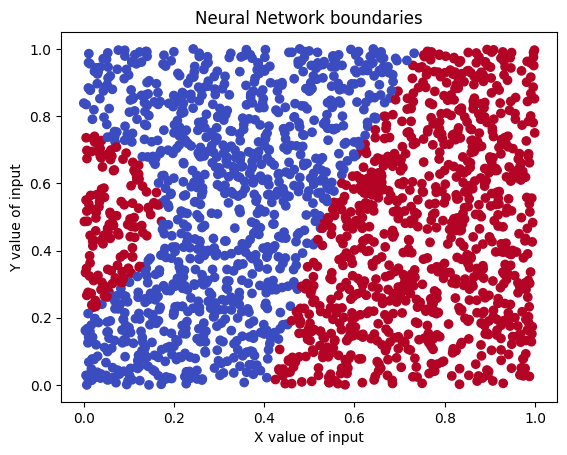

In [11]:
nn.visual_NN_boundaries()

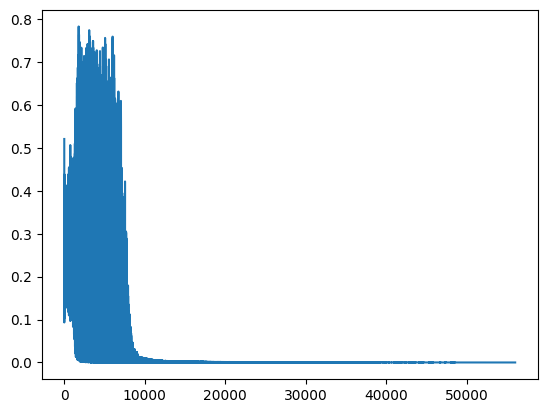

In [965]:
plt.plot(np.power(nn.loss, 2))